In [1]:
import torch
from utils import *
from collections import defaultdict
import matplotlib.pyplot as plt
import time

from models.rendering import render_rays
from models.nerf import *

import metrics

from datasets.blender import BlenderDataset

dataset = BlenderDataset('/home/ubuntu/data/nerf_example_data/nerf_synthetic/lego/', 'test',
                         img_wh=(400, 400))

In [2]:
embedding_xyz = Embedding(3, 10)
embedding_dir = Embedding(3, 4)

nerf_coarse = NeRF()
nerf_fine = NeRF()

ckpt_path = 'ckpts/exp2/epoch=05.ckpt'

load_ckpt(nerf_coarse, ckpt_path, model_name='nerf_coarse')
load_ckpt(nerf_fine, ckpt_path, model_name='nerf_fine')

nerf_coarse.cuda().eval()
nerf_fine.cuda().eval();

In [3]:
models = [nerf_coarse, nerf_fine]
embeddings = [embedding_xyz, embedding_dir]

N_samples = 64
N_importance = 64

def decode_batch(batch):
    rays = batch['rays'] # (B, 8)
    rgbs = batch['rgbs'] # (B, 3)
    return rays, rgbs

@torch.no_grad()
def f(rays):
    """Do batched inference on rays using chunk."""
    B = rays.shape[0]
    chunk = 1024*32
    results = defaultdict(list)
    for i in range(0, B, chunk):
        rendered_ray_chunks = \
            render_rays(models,
                        embeddings,
                        rays[i:i+chunk],
                        N_samples,
                        False,
                        0,
                        0,
                        N_importance,
                        chunk,
                        dataset.white_back)

        for k, v in rendered_ray_chunks.items():
            results[k] += [v]

    for k, v in results.items():
        results[k] = torch.cat(v, 0)
    return results

In [9]:
rays, rgbs = decode_batch(dataset[10])
rays = rays.cuda()

t = time.time()
results = f(rays)
torch.cuda.synchronize()
print(time.time()-t)

6.234585285186768


PSNR 28.636722564697266


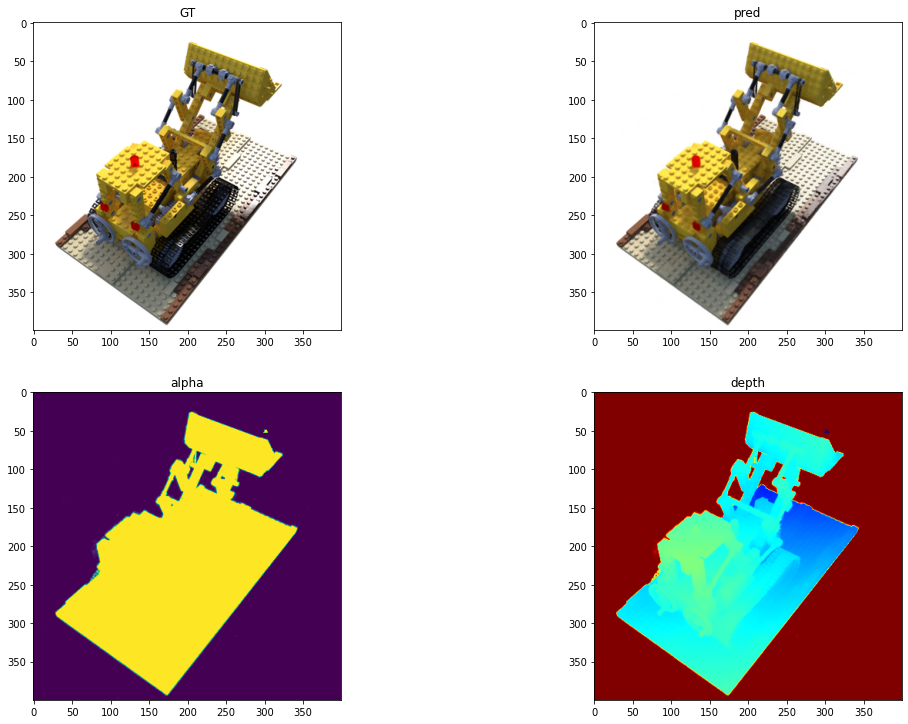

In [10]:
img_gt = rgbs.view(400, 400, 3)
img_pred = results['rgb_fine'].view(400, 400, 3).cpu().numpy()
alpha_pred = results['opacity_fine'].view(400, 400).cpu().numpy()
depth_pred = results['depth_fine'].view(400,400)

print('PSNR', metrics.psnr(img_gt, img_pred).item())

plt.subplots(figsize=(15, 10))
plt.tight_layout()
plt.subplot(221)
plt.title('GT')
plt.imshow(img_gt)
plt.subplot(222)
plt.title('pred')
plt.imshow(img_pred)
plt.subplot(223)
plt.title('alpha')
plt.imshow(alpha_pred)
plt.subplot(224)
plt.title('depth')
plt.imshow(visualize_depth(depth_pred).permute(1,2,0))
plt.show()